In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
import os
current_dir = os.getcwd()
os.chdir(current_dir.replace('\code', '\data'))

- Expected fantasy points based on individual stats (excluding yds, tds, rec, fumbles...)
- Maybe have rushing fantasy points, receiving fantasy points, and passing fantasy points instead of one big fantasy points feature
- Real fantasy points
- Expected fantasy points based on opportunity and team offense success
- Athletic score based on combine stats (momentum and distance)
- Draft pick feature
- Clustering feature that describes career performance (make a new table that is the yearly performance of a player and then use a cluster analysis to characterize different patterns like Rookie or Washed)
- try to make a "competition" df that finds/groups players by teams and sums targets/rushes of other players on the team. the only problem would be when a player played on two teams that year.
- make large dfs that can then be fed into a MLP to summarize the dfs for consistency, then compile them and further analyze for predictability

In [2]:
# Load data
gross_passing = pd.read_csv('gross_pfr_passing.csv')
gross_rushing = pd.read_csv('gross_pfr_rushing.csv')
gross_receiving = pd.read_csv('gross_pfr_receiving.csv')
gross_team_offense = pd.read_csv('gross_pfr_team_offense.csv')
gross_combine = pd.read_csv('gross_pfr_combine.csv')

# Transform Data

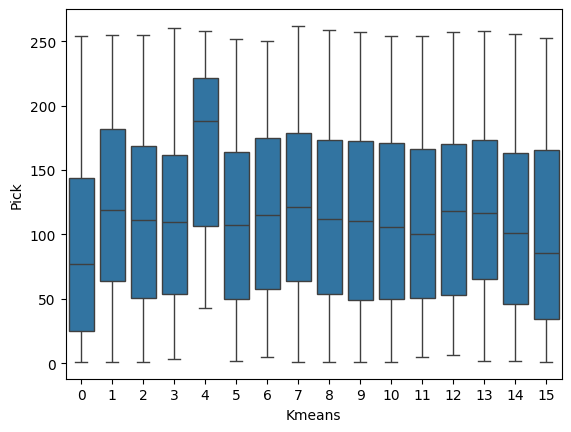

In [27]:
# Athletic Clustering
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for position
combine_clustering = gross_combine.copy()

# Save Pick column to df
df = combine_clustering[['Pick', 'Pos']]

# Select columns for clustering
combine_clustering = combine_clustering[['Wt', 'Height', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']]

# Convert categorical data to numeric
combine_clustering = combine_clustering.apply(pd.to_numeric, errors='coerce')

# Replace NaN with -1
combine_clustering.fillna(-1, inplace=True)

# Standardize the data
scaler = StandardScaler()
combine_clustering_scaled = scaler.fit_transform(combine_clustering)

# Kmeans
n_percent = int(combine_clustering.shape[0] * 0.05)
kmeans = KMeans(n_clusters=16, n_init=n_percent)
kmeans.fit(combine_clustering_scaled)
combine_clustering['Kmeans'] = kmeans.labels_

# Add Pick column back to df
combine_clustering = pd.concat([combine_clustering, df], axis=1)

# Plot clusters against Pick
sns.boxplot(x='Kmeans', y='Pick', data=combine_clustering)
plt.show()

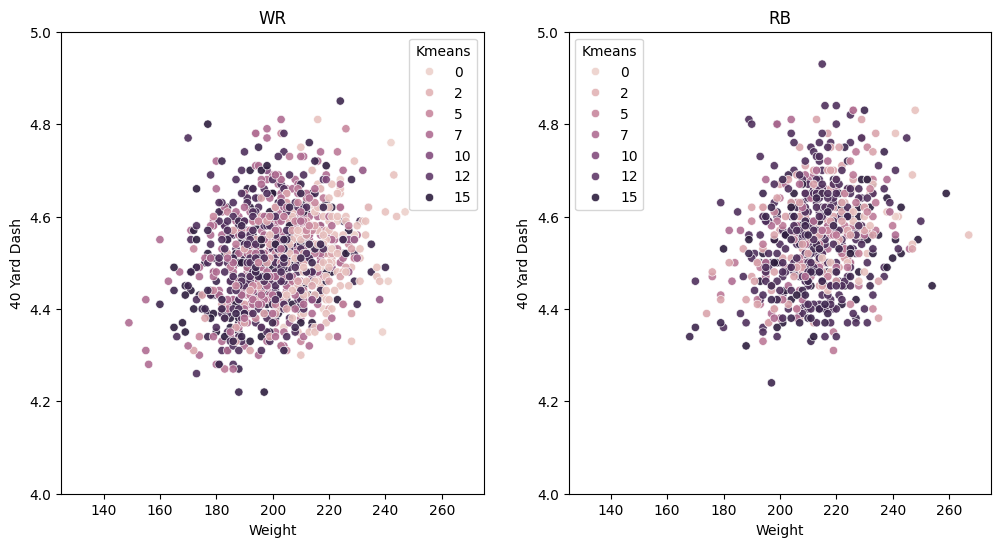

In [32]:
# Plot weight against 40yd
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('WR')
sns.scatterplot(x='Wt', y='40yd', hue='Kmeans', data=combine_clustering[combine_clustering["Pos"] == 'WR'], alpha=0.9)
plt.xlabel('Weight')
plt.ylabel('40 Yard Dash')
plt.xlim(125, 275)
plt.ylim(4, 5)

plt.subplot(1, 2, 2)
plt.title('RB')
sns.scatterplot(x='Wt', y='40yd', hue='Kmeans', data=combine_clustering[combine_clustering["Pos"] == 'RB'], alpha=0.9)
plt.xlabel('Weight')
plt.ylabel('40 Yard Dash')
plt.xlim(125, 275)
plt.ylim(4, 5)

plt.show()

In [3]:
# Future Passing Points

# Save player, passing_points, and year columns to future
future = gross_passing[['Player', 'Passing_Points', 'Year']]
future['Year'] = future['Year'] - 1
future = future.rename(columns={'Passing_Points': 'Future_Passing_Points'})

# Merge future with gross_passing on Player and Year
gross_passing = pd.merge(gross_passing, future, on=['Player', 'Year'], how='left')

gross_passing.head()

C:\Users\Jack\AppData\Local\Temp\ipykernel_15260\1769263533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['Year'] = future['Year'] - 1


,Player,Age,Tm,Pos,G,GS,Cmp,Att,Cmp%,Yds,...,ANY/A,4QC,GWD,Wins,ProBowl,AllPro,MVP,Passing_Points,Year,Future_Passing_Points
0,Drew Brees,33.0,NOR,QB,16.0,16.0,422.0,670.0,63.0,5177.0,...,7.17,1.0,2.0,7.0,1,0,0,341.08,2012,338.48
1,Matthew Stafford,24.0,DET,QB,16.0,16.0,435.0,727.0,59.8,4967.0,...,5.81,3.0,3.0,4.0,0,0,0,244.68,2012,264.00
2,Tony Romo,32.0,DAL,QB,16.0,16.0,425.0,648.0,65.6,4903.0,...,6.35,5.0,5.0,8.0,0,0,0,270.12,2012,257.12
3,Tom Brady,35.0,NWE,QB,16.0,16.0,401.0,637.0,63.0,4827.0,...,7.48,1.0,2.0,12.0,1,1,0,313.08,2012,251.72
4,Matt Ryan,27.0,ATL,QB,16.0,16.0,422.0,615.0,68.6,4719.0,...,7.03,4.0,6.0,13.0,1,0,0,288.76,2012,250.60


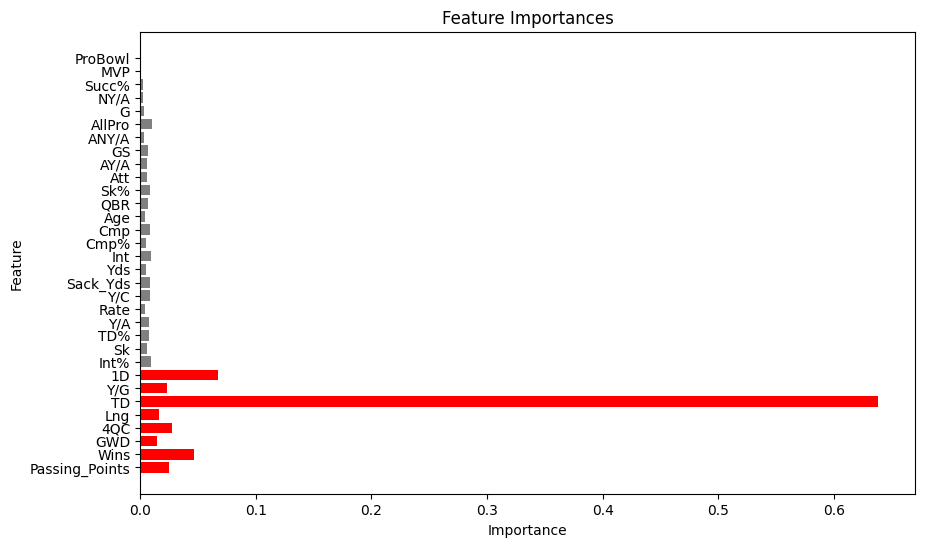

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import pandas as pd

# Load data
gross_passing = gross_passing.dropna(subset=['Future_Passing_Points']).reset_index(drop=True)
gross_passing = gross_passing.fillna(-1)
columns_to_drop = ['Player', 'Tm', 'Pos', 'Year', 'Future_Passing_Points']
X = gross_passing.drop(columns=columns_to_drop)
y = gross_passing['Future_Passing_Points']

def feature_selection(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Initialize the model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

    # Initialize RFE with the model
    rfe = RFE(estimator=model, n_features_to_select=0.25, step=1)

    # Fit RFE
    rfe.fit(X_train, y_train)

    # Get the ranking of features
    ranking = rfe.ranking_

    # Get the support (selected features)
    support = rfe.support_

    # Fit the model on the entire training data to get feature importances
    model.fit(X_train, y_train)

    # Get the feature importances
    feature_importances = model.feature_importances_

    # Create a DataFrame to display the results
    feature_ranking_df = pd.DataFrame({
        'Feature': X.columns,
        'Ranking': ranking,
        'Selected': support,
        'Importance': feature_importances
    })

    # Sort the DataFrame by ranking
    feature_ranking_df = feature_ranking_df.sort_values(by='Ranking')

    return feature_ranking_df

# Get the feature ranking
feature_ranking_df = feature_selection(X, y)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking_df['Feature'], feature_ranking_df['Importance'], color=feature_ranking_df['Selected'].map({True: 'red', False: 'gray'}))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [13]:
# Future Rushing Points

# Save player, rushing_points, and year columns to future
future = gross_rushing[['Player', 'Rushing_Points', 'Year']]
future['Year'] = future['Year'] - 1
future = future.rename(columns={'Rushing_Points': 'Future_Rushing_Points'})

# Merge future with gross_rushing on Player and Year
gross_rushing = pd.merge(gross_rushing, future, on=['Player', 'Year'], how='left')

gross_rushing.head()

C:\Users\Jack\AppData\Local\Temp\ipykernel_15260\3558931947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['Year'] = future['Year'] - 1


,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,...,Y/A,Y/G,Fmb,Player-additional,AllPro,ProBowl,Rushing_Points,Year,Succ%,Future_Rushing_Points
0,Arian Foster,HOU,26,RB,16,16,351,1424,15,78,...,4.1,89.0,3,FostAr00,0,1,226.4,2012,NaN,60.2
1,Adrian Peterson,MIN,27,RB,16,16,348,2097,12,88,...,6.0,131.1,4,PeteAd01,1,1,273.7,2012,NaN,176.6
2,Alfred Morris,WAS,24,RB,16,16,335,1613,13,86,...,4.8,100.8,4,MorrAl00,0,0,231.3,2012,NaN,159.5
3,Doug Martin,TAM,23,RB,16,16,319,1454,11,64,...,4.6,90.9,1,MartDo00,0,1,209.4,2012,NaN,47.6
4,Marshawn Lynch,SEA,26,RB,16,15,315,1590,11,70,...,5.0,99.4,5,LyncMa00,1,1,215.0,2012,NaN,189.7


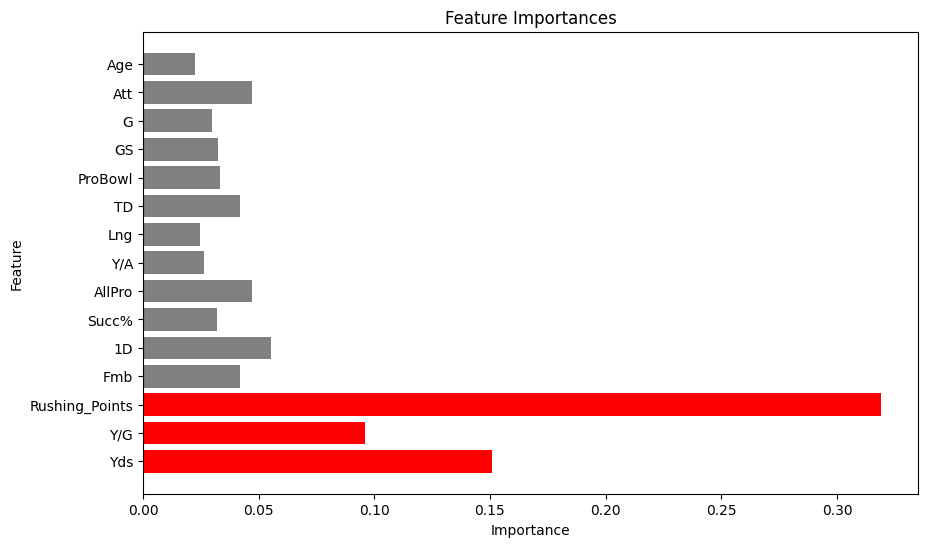

In [14]:
# Rushing Points Subset Selection
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Vectors to store R^2 and MAE
r_squared_scores = []
mae_scores = []

# Load data
gross_rushing = gross_rushing.dropna(subset=['Future_Rushing_Points']).reset_index(drop=True)
gross_rushing = gross_rushing.fillna(-1)
columns_to_drop = ['Player', 'Tm', 'Pos', 'Year', 'Future_Rushing_Points', 'Player-additional']
X = gross_rushing.drop(columns=columns_to_drop)

y = gross_rushing['Future_Rushing_Points']

# Get the feature ranking
feature_ranking_df = feature_selection(X, y)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking_df['Feature'], feature_ranking_df['Importance'], color=feature_ranking_df['Selected'].map({True: 'red', False: 'gray'}))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [15]:
# Future Receiving Points

# Save player, receiving_points, and year columns to future
future = gross_receiving[['Player', 'Receiving_Points', 'Year']]
future['Year'] = future['Year'] - 1
future = future.rename(columns={'Receiving_Points': 'Future_Receiving_Points'})

# Merge future with gross_receiving on Player and Year
gross_receiving = pd.merge(gross_receiving, future, on=['Player', 'Year'], how='left')

gross_receiving.head()

C:\Users\Jack\AppData\Local\Temp\ipykernel_15260\3614531113.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['Year'] = future['Year'] - 1


,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,...,Y/Tgt,R/G,Y/G,Fmb,Player-additional,AllPro,ProBowl,Receiving_Points,Year,Future_Receiving_Points
0,Calvin Johnson,DET,27,WR,16,16,204,122,59.8,1964,...,9.6,7.6,122.8,3,JohnCa00,1,1,287.4,2012,263.2
1,Brandon Marshall,CHI,28,WR,16,16,192,118,61.5,1508,...,7.9,7.4,94.3,2,MarsBr00,1,1,275.8,2012,251.5
2,Wes Welker,NWE,31,WR,16,12,174,118,67.8,1354,...,7.8,7.4,84.6,3,WelkWe00,0,1,230.4,2012,174.3
3,Andre Johnson,HOU,31,WR,16,16,162,112,69.1,1598,...,9.9,7.0,99.9,0,JohnAn02,0,1,239.8,2012,225.2
4,Jason Witten,DAL,30,TE,16,16,147,110,74.8,1039,...,7.1,6.9,64.9,0,WittJa00,0,1,176.9,2012,169.6


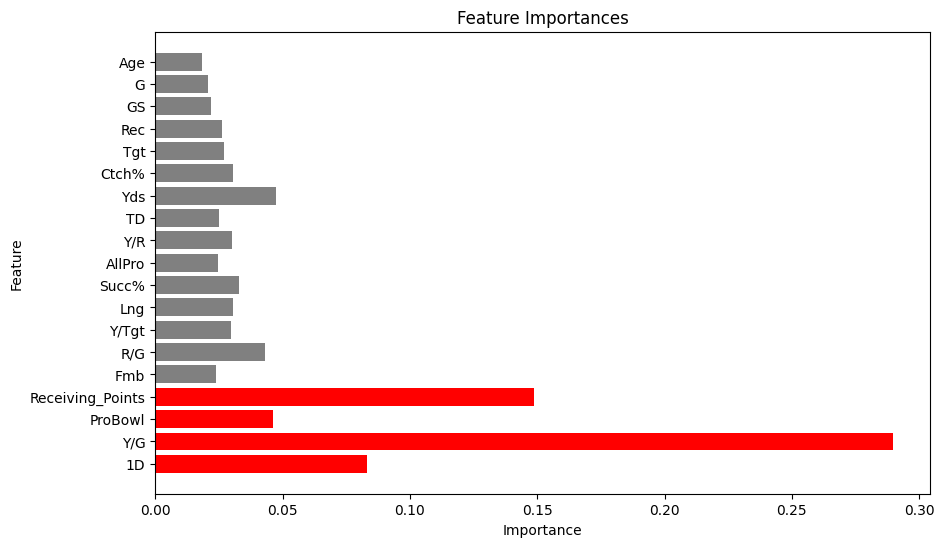

In [16]:
# Receiving Points Subset Selection
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Vectors to store R^2 and MAE
r_squared_scores = []
mae_scores = []

# Load data
gross_receiving = gross_receiving.dropna(subset=['Future_Receiving_Points']).reset_index(drop=True)
gross_receiving = gross_receiving.fillna(-1)
columns_to_drop = ['Player', 'Tm', 'Pos', 'Year', 'Future_Receiving_Points', 'Player-additional']
X = gross_receiving.drop(columns=columns_to_drop)
y = gross_receiving['Future_Receiving_Points']

# Get the feature ranking
feature_ranking_df = feature_selection(X, y)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking_df['Feature'], feature_ranking_df['Importance'], color=feature_ranking_df['Selected'].map({True: 'red', False: 'gray'}))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [23]:
# Career Clustering
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def career_averaging(df, target_column):
    # Prepare the data
    df = df[['Player', target_column, 'Year']]

    # Aggregate data to ensure unique Player-Year combinations
    df = df.groupby(['Player', 'Year']).agg({target_column: 'mean'}).reset_index()

    # Pivot the data on Year
    df_pivot = df.pivot(index='Player', columns='Year', values=target_column).reset_index()

    # Save players
    players = df_pivot['Player']
    df_pivot = df_pivot.drop(columns=['Player'])

    # For every column, average the previous years
    player_career = pd.DataFrame()
    for i in range(1, df_pivot.shape[1] + 1):
        player_career[i] = df_pivot.iloc[:, 0:i].mean(axis=1)

    # Rename each column to the year
    first_year_column = df_pivot.columns[0]
    player_career.columns = [str(i) for i in range(first_year_column+1, first_year_column + df_pivot.shape[1]+1)]
    player_career['Player'] = players

    return player_career

passing_career = career_averaging(gross_passing, 'Passing_Points')
rushing_career = career_averaging(gross_rushing, 'Rushing_Points')
receiving_career = career_averaging(gross_receiving, 'Receiving_Points')

receiving_career.head()

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Player
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.100000,193.800000,178.666667,198.9000,A.J. Brown
1,249.5,253.55,227.233333,228.6,213.56,210.183333,210.183333,210.183333,192.700000,184.837500,184.8375,A.J. Green
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.300000,47.4500,AJ Dillon
3,NaN,NaN,NaN,NaN,NaN,NaN,39.600000,64.750000,66.833333,75.400000,80.1200,Aaron Jones
4,NaN,NaN,NaN,45.5,73.60,82.266667,99.100000,92.860000,85.100000,85.100000,85.1000,Adam Humphries


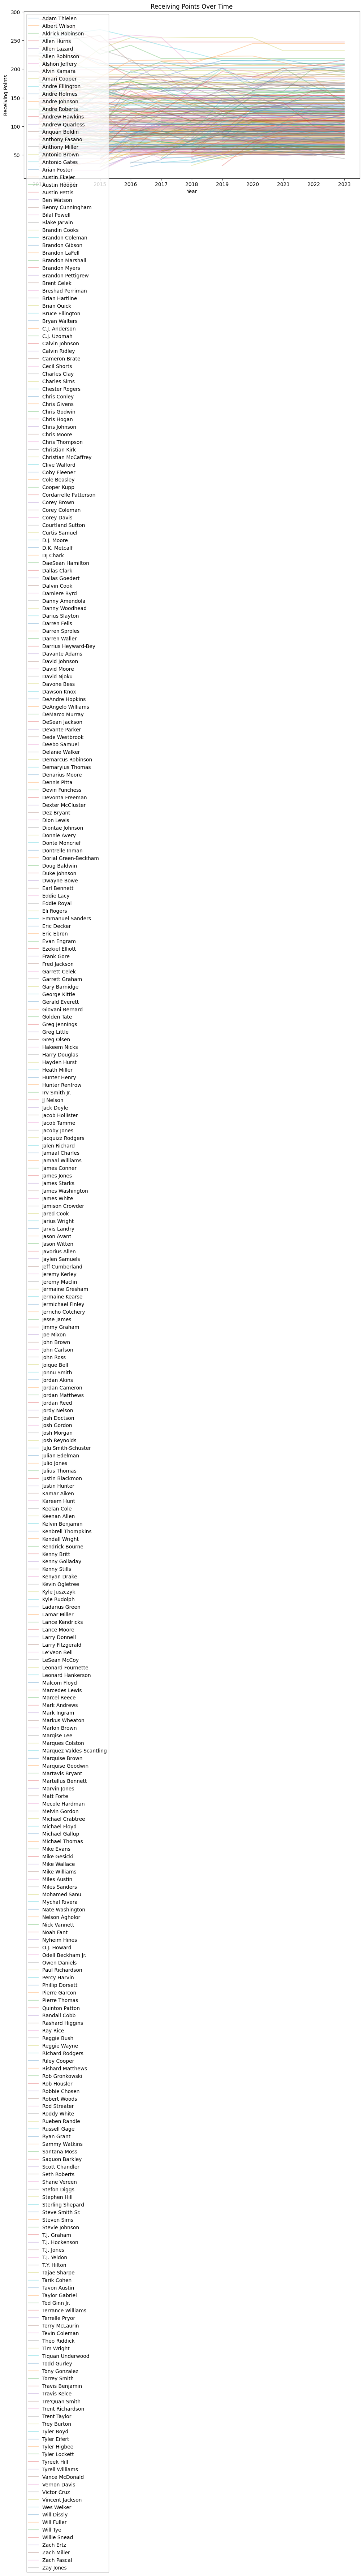

In [25]:
# Line plot of recieving career
df = receiving_career[receiving_career['2020'] >= 50]
plt.figure(figsize=(12, 6))
for i in range(4, df.shape[0]):
    plt.plot(df.iloc[i, :-1], label=df.iloc[i, -1], alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Receiving Points')
plt.title('Receiving Points Over Time')
plt.legend()
plt.show()